d:\Venv\envs\TarRec\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_2']
Received: inputs=Tensor(shape=(32, 128, 128, 1))
  warnings.warn(msg)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


d:\Venv\envs\TarRec\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_2']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step

d:\Venv\envs\TarRec\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_2']
Received: inputs=Tensor(shape=(32, 128, 128, 1, 1))
  warnings.warn(msg)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


d:\Venv\envs\TarRec\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_2']
Received: inputs=Tensor(shape=(None, 128, 128, 1, 1))
  warnings.warn(msg)


 3/15 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 

d:\Venv\envs\TarRec\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_6']
Received: inputs=Tensor(shape=(32, 128, 128, 1))
  warnings.warn(msg)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


d:\Venv\envs\TarRec\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_6']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6564 - loss: 0.7383 - val_accuracy: 1.0000 - val_loss: 0.1207 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9819 - loss: 0.1163 - val_accuracy: 1.0000 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9927 - loss: 0.0398 - val_accuracy: 1.0000 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9879 - loss: 0.0378 - val_accuracy: 1.0000 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9927 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss: 5.4333e-04 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 2.9053e

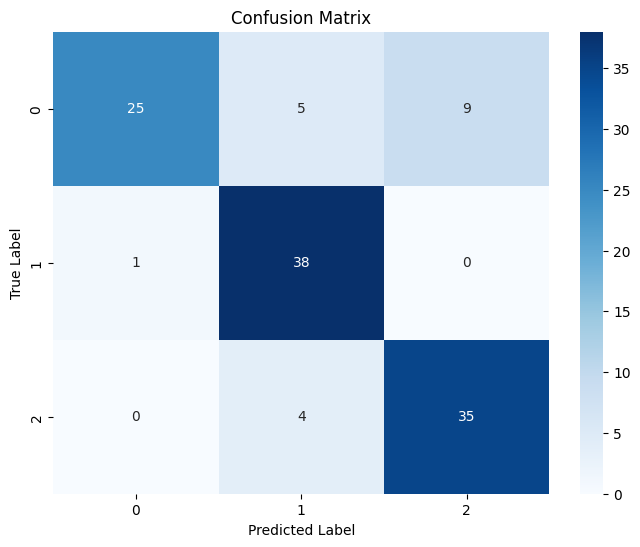

✅ 动态门控融合模型已保存为 cnn_gate_fusion_with_snr_lhr_weights.keras


In [17]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate,Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# **自定义加权融合层**
class WeightedFusionLayer(Layer):
    def __init__(self, **kwargs):
        super(WeightedFusionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        gate_output, x_mfcc, x_wavelet, x_dd = inputs

        # 对每个特征进行加权
        weighted_mfcc = tf.multiply(gate_output[:, 0:1], x_mfcc)
        weighted_wavelet = tf.multiply(gate_output[:, 1:2], x_wavelet)
        weighted_dd = tf.multiply(gate_output[:, 2:3], x_dd)

        # 将加权后的特征连接在一起
        return tf.concat([weighted_mfcc, weighted_wavelet, weighted_dd], axis=-1)

# **设置随机种子**
SEED = 400   #300的时候效果不错
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# **1️⃣ 加载训练好的 CNN 模型**
model_mfcc = load_model(r"D:\Dataset\Marine-Mammal-Target-Classification\03_CNN\cnn_MFCC_model.keras")
model_wavelet = load_model(r"D:\Dataset\Marine-Mammal-Target-Classification\03_CNN\cnn_wavelet_model_abs.keras")
model_dd = load_model(r"D:\Dataset\Marine-Mammal-Target-Classification\03_CNN\cnn_DelayDoppler_model.keras")

# **2️⃣ 提取特征层**
feature_extractor_mfcc = Model(inputs=model_mfcc.inputs, outputs=model_mfcc.get_layer("dense_4").output)
feature_extractor_wavelet = Model(inputs=model_wavelet.inputs, outputs=model_wavelet.get_layer("dense_4").output)
feature_extractor_dd = Model(inputs=model_dd.inputs, outputs=model_dd.get_layer("dense_12").output)

# **3️⃣ 加载训练数据和测试数据**
X_train_mfcc = np.load(r"D:\Dataset\Temp_Results\MFCC\X_train_mfcc_cnn.npy")
X_train_wavelet = np.load(r"D:\Dataset\Temp_Results\Wavelet\X_train_cwt_abs.npy")
X_train_wavelet = np.expand_dims(X_train_wavelet, axis=-1)
X_train_dd = np.load(r"D:\Dataset\Temp_Results\DelayDoppler\X_train_dd_cnn.npy")
Y_train = np.load(r"D:\Dataset\Temp_Results\Train_Test\y_train.npy")

X_test_mfcc = np.load(r"D:\Dataset\Temp_Results\MFCC\X_test_mfcc_cnn.npy")
X_test_wavelet = np.load(r"D:\Dataset\Temp_Results\Wavelet\X_test_cwt_abs.npy")
X_test_wavelet = np.expand_dims(X_test_wavelet, axis=-1)
X_test_dd = np.load(r"D:\Dataset\Temp_Results\DelayDoppler\X_test_dd_cnn.npy")
Y_test = np.load(r"D:\Dataset\Temp_Results\Train_Test\y_test.npy")

# **4️⃣ 归一化数据**
X_train_mfcc = X_train_mfcc.astype(np.float32) / 255.0
X_train_wavelet = X_train_wavelet.astype(np.float32) / 255.0
X_train_dd = X_train_dd.astype(np.float32) / 255.0

X_test_mfcc = X_test_mfcc.astype(np.float32) / 255.0
X_test_wavelet = X_test_wavelet.astype(np.float32) / 255.0
X_test_dd = X_test_dd.astype(np.float32) / 255.0

# **5️⃣ 提取三个模型的特征**
features_train_mfcc = feature_extractor_mfcc.predict(X_train_mfcc)
features_train_wavelet = feature_extractor_wavelet.predict(X_train_wavelet)
features_train_dd = feature_extractor_dd.predict(X_train_dd)

features_test_mfcc = feature_extractor_mfcc.predict(X_test_mfcc)
features_test_wavelet = feature_extractor_wavelet.predict(X_test_wavelet)
features_test_dd = feature_extractor_dd.predict(X_test_dd)

# **6️⃣ 加载 SNR 和 LHR**
snr_lhr_train = np.load(r"D:\Dataset\Temp_Results\SNRandLHR\SNR_LHR_train.npy", allow_pickle=True)
snr_lhr_test = np.load(r"D:\Dataset\Temp_Results\SNRandLHR\SNR_LHR_test.npy", allow_pickle=True)

# **7️⃣ 处理标签**
num_classes = len(np.unique(Y_train))
Y_train = to_categorical(Y_train, num_classes)
Y_test = to_categorical(Y_test, num_classes)

# **8️⃣ 提取 SNR 和 LHR 特征**
snr_lhr_train_features = np.array([row[1:] for row in snr_lhr_train], dtype=np.float32)
snr_lhr_test_features = np.array([row[1:] for row in snr_lhr_test], dtype=np.float32)

# **9️⃣ 创建输入层和门控网络**
input_mfcc = Input(shape=(features_train_mfcc.shape[1],), name="input_mfcc")
input_wavelet = Input(shape=(features_train_wavelet.shape[1],), name="input_wavelet")
input_dd = Input(shape=(features_train_dd.shape[1],), name="input_dd")
input_snr_lhr = Input(shape=(snr_lhr_train_features.shape[1],), name="input_snr_lhr")

# 将每个输入层传入各自的全连接层进行处理
x_mfcc = Dense(128, activation='relu')(input_mfcc)
x_wavelet = Dense(128, activation='relu')(input_wavelet)
x_dd = Dense(128, activation='relu')(input_dd)

# **10️⃣ 门控网络**
x_snr_lhr = Dense(64, activation='relu')(input_snr_lhr)
gate_output = Dense(3, activation='softmax', name="gate_output")(x_snr_lhr)

# **11️⃣ 将门控网络与特征网络连接**
# 使用门控网络的输出对三个特征进行加权融合
weighted_features = WeightedFusionLayer()([gate_output, x_mfcc, x_wavelet, x_dd])

# 进行一些后续处理
x = Dense(128, activation='relu')(weighted_features)
x = Dropout(0.4)(x)
x = Dense(num_classes, activation='softmax')(x)

# **12️⃣ 创建最终的融合模型**
dynamic_fusion_model = Model(inputs=[input_mfcc, input_wavelet, input_dd, input_snr_lhr], outputs=x)

# **🔟 编译模型**
dynamic_fusion_model.compile(optimizer=Adam(learning_rate=0.001),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

# **1️⃣1️⃣ 训练模型**
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = dynamic_fusion_model.fit([features_train_mfcc, features_train_wavelet, features_train_dd, snr_lhr_train_features],
                                   Y_train, epochs=20, batch_size=32, validation_split=0.2,
                                   callbacks=[reduce_lr, early_stopping])

# **1️⃣2️⃣ 评估融合模型**
test_loss, test_acc = dynamic_fusion_model.evaluate([features_test_mfcc, features_test_wavelet, features_test_dd, snr_lhr_test_features],
                                                    Y_test, verbose=2)
print(f"\n✅ 动态门控融合模型测试集准确率: {test_acc:.4f}")

# **1️⃣3️⃣ 计算分类报告和混淆矩阵**
Y_pred = dynamic_fusion_model.predict([features_test_mfcc, features_test_wavelet, features_test_dd, snr_lhr_test_features])
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

print("\n📊 分类报告:")
print(classification_report(Y_true, Y_pred_classes))

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(Y_true), yticklabels=np.unique(Y_true))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **1️⃣4️⃣ 保存最终融合模型**
dynamic_fusion_model.save(r"D:\Dataset\Temp_Results\Model\cnn_gate_fusion_with_snr_lhr_weights.keras")
print("✅ 动态门控融合模型已保存为 cnn_gate_fusion_with_snr_lhr_weights.keras")
